In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import os
import matplotlib.pyplot as plt

from IPython import display
from PIL import Image
from tqdm import tqdm

from src.preprocessing.image_sampling import create_sample, downscale_images
from src.preprocessing.preprocessing import preprocess
from src.evaluation.losses import generator_loss, discriminator_loss, combined_metric
from src.misc.plotting import plot_loss
from src.misc.saving import generate_and_save_images, save_loss

from src.models.wgan_gp import create_generator, create_discriminator, WGAN_GP

from tensorflow.keras.models import load_model

# Data Processing

In [2]:
create_sample(input_dir='./data/all_images/img_align_celeba/img_align_celeba/',
                    output_dir='./data/10000_images/',
                    sample_size=10000)

Files shuffled with seed 42.


KeyboardInterrupt: 

In [ ]:
downscale_images(input_dir='./data/10000_images/',
                 output_dir='./data/10000_images_downscaled/',
                 output_size=(64,64))

Processed all 10000 files


In [18]:
ds = tf.data.Dataset.list_files('./data/10000_images_downscaled/*')

ds = ds.map(preprocess(tanh=True)).batch(32)

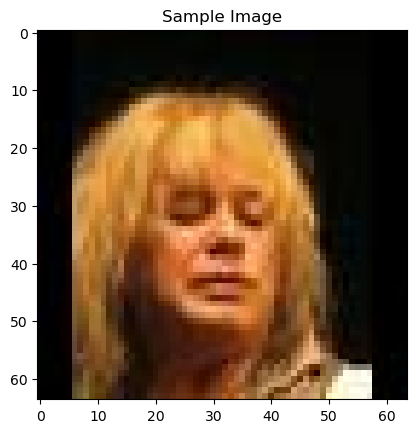

In [19]:
sample = next(iter(ds))
sample_image = sample[0].numpy()
plt.title('Sample Image')
plt.imshow(sample_image*0.5 + 0.5)

# Model

In [20]:
LATENT_DIM = 100
EPOCHS = 100
BATCH_SIZE = 32

In [21]:
generator =  create_generator(input_shape=LATENT_DIM)
discriminator = create_discriminator(input_shape=(64, 64, 3))

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, 
									beta_1=0.5,
									beta_2=0.9
									)

discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, 
									beta_1=0.5,
									beta_2=0.9
									)

In [22]:
wgan_gp = WGAN_GP(generator, discriminator, latent_dim=LATENT_DIM)

wgan_gp.compile(
    disc_optimizer=discriminator_optimizer,
    gen_optimizer=generator_optimizer,
    disc_loss_fn=discriminator_loss,
    gen_loss_fn=generator_loss,
)

In [29]:
checkpoint_dir = './src/model_checkpoints/wgan_gp_checkpoints/'
checkpoint_prefix = checkpoint_dir + "wgan_gp_ckpt"

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

checkpoint_manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, checkpoint_name=checkpoint_prefix, max_to_keep=1)


try:
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

    batch = next(iter(ds))

    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    gen_images = generator(noise)

    real_output = discriminator(batch, training=False)
    fake_output = discriminator(gen_images, training=False)

    disc_loss = discriminator_loss(real_logits=real_output, fake_logits=fake_output)
    gen_loss = generator_loss(fake_logits=fake_output)

    best_combined_loss = combined_metric(gen_loss=gen_loss, disc_loss=disc_loss, alpha=0.75)

    print("Model loaded successfully from checkpoint.")
except:
    best_combined_loss = np.inf
    print(f"Error: Checkpoint file '{checkpoint_prefix}' not found. Model not loaded.")
    

Model loaded successfully from checkpoint.


In [32]:
@tf.function
def train_step(wgan, images):
    return wgan.train_step(images)

Epoch 100 took 64.10476183891296 seconds


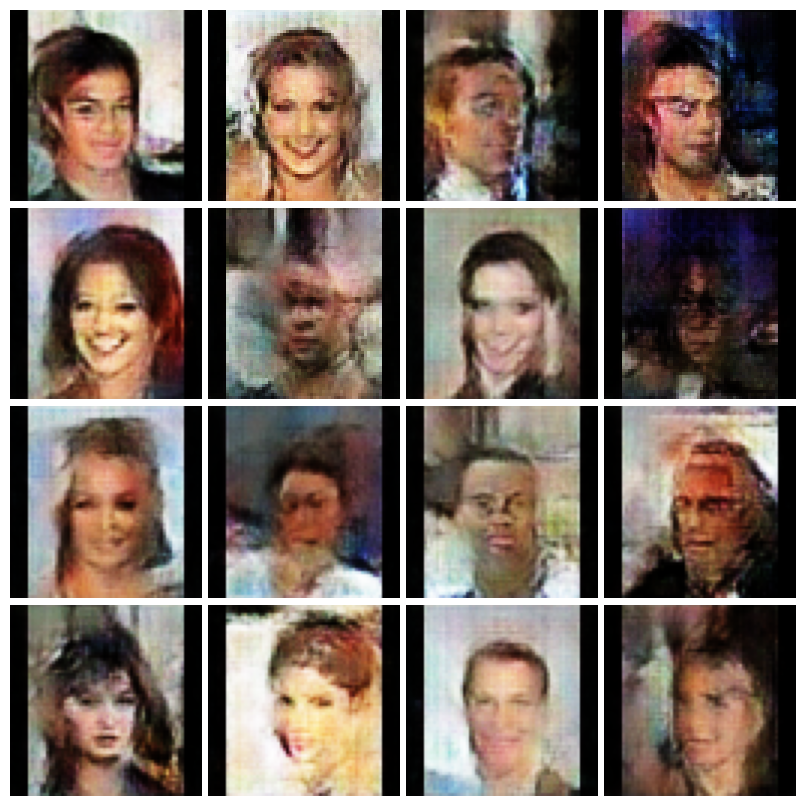

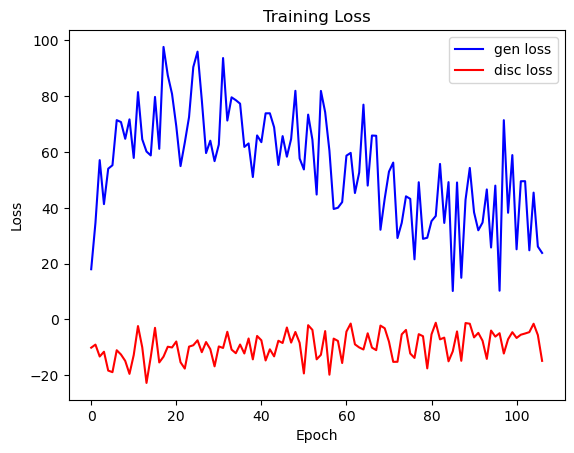

Epoch 100/100


In [33]:
# Generate a fixed noise vector for image generation
tf.random.set_seed(42)
fixed_noise = tf.random.normal([16, LATENT_DIM])
best_combined_loss = np.inf
loss_path = './src/model_training_losses/wgan_gp_train_loss.csv'
image_dir = './src/training_images/wgan_gp_images/'

for epoch in range(EPOCHS):
    
    start = time.time()

    for batch in tqdm(ds):
        dict = train_step(wgan_gp, batch)
    
    end = time.time()

    gen_loss = dict['gen_loss'].numpy()
    disc_loss = dict['disc_loss'].numpy()

    # Save loss
    save_loss(loss_path=loss_path, gen_loss=gen_loss, disc_loss=disc_loss)

    # Generate plots
    display.clear_output(wait=True)
    print(f'Epoch {epoch+1} took {end - start} seconds')
    generate_and_save_images(model=wgan_gp, noise=fixed_noise, epoch=epoch + 1, image_dir=image_dir)
    plot_loss(loss_path=loss_path)

    # Check loss
    combined_loss = combined_metric(gen_loss, disc_loss, alpha = 0.75)
    if combined_loss < best_combined_loss:
        best_loss = combined_loss
        checkpoint_manager.save()
    
    print(f'Epoch {epoch+1}/{EPOCHS}')